## Notebook para Treinamento e Avaliação de Modelos Shallow

Baseado no artigo: Neural Networks Forecast Models Comparison for the Solar Energy Generation in Amazon Basin

>Replicação Fiel

### 1. Importação das Bibliotecas

In [122]:
!pip install matplotlib pandas numpy scikit-learn statsmodels xgboost scipy

In [123]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from scipy.stats import uniform as sp_uniform, randint as sp_randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### 2. Configuração Inicial e Parâmetros

In [124]:
warnings.filterwarnings("ignore")

In [125]:
STATIONS = [
    {"city": "Barcelos", "dataset": "bar.csv"},
    {"city": "Benjamin Constant", "dataset": "bjc.csv"},
    {"city": "Coari", "dataset": "coa.csv"},
    {"city": "Codajas", "dataset": "cod.csv"},
    {"city": "Eirunepe", "dataset": "eir.csv"},
    {"city": "Iaurete", "dataset": "iau.csv"},
    {"city": "Labrea", "dataset": "lab.csv"},
    {"city": "Manaus", "dataset": "mna.csv"},
    {"city": "Manicore", "dataset": "mnc.csv"},
    {"city": "Parintins", "dataset": "par.csv"},
    {"city": "S.G.Cachoeira", "dataset": "sgc.csv"},
    {"city": "Tefe", "dataset": "tef.csv"},
]
STATION_SELECTED = 11 # Índice da estação selecionada na lista STATIONS
STATION = STATIONS[STATION_SELECTED]['city'] # Nome da estação/cidade
FILEPATH = f"data/{STATIONS[STATION_SELECTED]['dataset']}" # Caminho para o arquivo de dados CSV
DATE_COL = "date_m" # Nome da coluna de datas
TARGET_VARIABLE = "ALLSKY_SFC_SW_DWN"
WEATHER_FEATURES = ["ALLSKY_KT", "T2M", "RH2M", "WS10M"]
PRED_LEN = 30 # Horizonte de previsão (holdout)
RANDOM_STATE = 42
N_CV_SPLITS = 5 # número de splits
N_ITER_BACKTEST = 20 # Número de iterações do RandomizedSearch em cada fold
SIMPLE_GAP = 1 # O gap para o modelo 'Fiel' é 1 (devido ao shift(1))
DO_BACKTEST = True

# Configurações de saída
SAVE_PLOTS = True
SAVE_RESULTS = True
PLOTS_FOLDER = 'plots/replicacao_fiel'
RESULTS_FOLDER = 'results/replicacao_fiel'

# Define a semente para reprodutibilidade
np.random.seed(RANDOM_STATE)

### 3. Definição das Funções Auxiliares

In [126]:
def replace_missing_with_mean(df: pd.DataFrame) -> pd.DataFrame:
    """Substitui -999.0 pela média (replicando o artigo)."""
    out = df.copy()
    for c in out.columns:
        if pd.api.types.is_numeric_dtype(out[c]):
            mask = out[c] != -999.0
            if mask.any():
                m = out.loc[mask, c].mean()
                out[c] = out[c].replace(-999.0, m)
    return out

# --- Funções de Métrica ---

def mape(y_true, y_pred):
    """Calcula o Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.inf
    return 100.0 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def smape(y_true, y_pred):
    """Calcula o Symmetric Mean Absolute Percentage Error (sMAPE)."""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    if not mask.any():
        return 0.0 # Se ambos são 0, o erro é 0
    return 100.0 * np.mean(2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask])

def mase(y_true, y_pred, y_train_in):
    """Calcula o Mean Absolute Scaled Error (MASE)."""
    y_train_in = np.asarray(y_train_in)
    denom = np.mean(np.abs(np.diff(y_train_in))) if len(y_train_in) > 1 else np.nan
    if denom is None or denom == 0 or np.isnan(denom):
        return np.nan 
    mae_model = np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)))
    return mae_model / denom

def calculate_metrics(y_true, y_pred, y_train_in, model_name, station_name, elapsed_s):
    """Calcula e formata um dicionário de métricas para um modelo."""
    return {
        "Model": model_name,
        "Station": station_name,
        "R2": round(r2_score(y_true, y_pred), 4),
        "MSE": round(mean_squared_error(y_true, y_pred), 4),
        "MAE": round(mean_absolute_error(y_true, y_pred), 4),
        "MAPE": round(mape(y_true, y_pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 4),
        "sMAPE(%)": round(smape(y_true, y_pred), 4),
        "MASE": round(mase(y_true, y_pred, y_train_in), 4),
        "Time(s)": round(elapsed_s, 2),
    }
    
# --- Funções de Plotagem ---

def plot_comparison(test_index, y_true, preds_dict, title, station_name, target_var, save=False, folder='plots_report'):
    """
    Plota um gráfico comparando o valor real contra N previsões.
    Funciona para N=1 (gráfico individual) ou N > 1 (gráfico comparativo).
    """
    plt.figure(figsize=(18, 10))
    plt.plot(test_index, y_true, label='Valor Real', marker='o', linestyle='-', linewidth=2.5, markersize=5)
        
    for name, pred in preds_dict.items():
        plt.plot(test_index, pred, label=name, linestyle='--', alpha=0.9, marker='x', markersize=4)
        
    plt.title(f'{title}\nCidade: {station_name}', fontsize=16)
    plt.ylabel(f'{target_var} (kW·h/m²)', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    
    if save:
        os.makedirs(folder, exist_ok=True)
        clean_title = title.lower().replace(' ', '_').replace(':', '').replace('\n', '_')
        clean_station = station_name.lower().replace(' ', '_')
        filename = f"{clean_station}_{clean_title}.png"
        plt.savefig(os.path.join(folder, filename), dpi=150)
    
    plt.show()

def plot_feature_importance(model, feature_names, model_name, station_name, top_n=8, save=False, folder='plots_report'):
    """Plota a importância das features para modelos baseados em árvore."""
    if not hasattr(model, 'feature_importances_'):
        print(f"O modelo {model_name} não possui o atributo 'feature_importances_'.")
        return
        
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    
    plt.figure(figsize=(10, max(6, top_n * 0.4)))
    plt.title(f'Top {top_n} Features - {model_name} - {station_name}', fontsize=14)
    plt.barh([feature_names[i] for i in indices], importances[indices], color='b', align='center')
    plt.xlabel('Importância Relativa', fontsize=12)
    plt.tight_layout()
    
    if save:
        os.makedirs(folder, exist_ok=True)
        clean_model = model_name.lower().replace(' ', '_')
        clean_station = station_name.lower().replace(' ', '_')
        plt.savefig(os.path.join(folder, f'feature_importance_{clean_model}_{clean_station}.png'), dpi=150)

    plt.show()

# --- Funções de Processamento ---

def build_features(df_idxed: pd.DataFrame, target_col: str, feature_cols: list, use_lag1=True):
    """Constrói os dataframes X e y para o modelo."""
    y = df_idxed[target_col].copy()
    
    if use_lag1:
        X = pd.DataFrame(index=df_idxed.index)
        for c in feature_cols:
            X[f"{c}_1"] = df_idxed[c].shift(1)
    else:
        X = df_idxed[feature_cols].copy()
        
    # Concatena e remove NaNs (gerados pelo shift)
    data = pd.concat([y, X], axis=1).dropna()
    return data[X.columns], data[target_col]
    
def fit_predict_eval(model, X_train, y_train, X_test, y_test, y_train_baseline, model_name, station_name):
    """
    Treina um modelo, gera predições, calcula métricas e retorna os resultados.
    """
    print(f"\nTreinando {model_name}")
    t0 = time.time()
    model.fit(X_train, y_train)
    y_pred = np.maximum(model.predict(X_test), 0.0) # Garante não-negatividade
    t1 = time.time()
    
    # Calcula métricas
    metrics = calculate_metrics(
        y_true=y_test, 
        y_pred=y_pred, 
        y_train_in=y_train_baseline,
        model_name=model_name, 
        station_name=station_name,
        elapsed_s=t1 - t0
    )
    
    return y_pred, metrics, model

def rolling_backtest_sklearn(estimator, param_distributions, X, y, n_splits=5, gap=0, n_iter=20, score='neg_mean_absolute_error', needs_scaler=False, name='Model'):
    """Realiza backtesting com TimeSeriesSplit e RandomizedSearchCV para modelos sklearn."""
    cv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    fold_metrics = []
    fold_idx = 0
    for train_idx, test_idx in cv.split(X):
        fold_idx += 1
        print(f"Backtest: {name} - Fold {fold_idx}/{n_splits}")
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        inner_cv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
        if needs_scaler:
            # O scaler é colocado DENTRO do pipeline para evitar data leakage entre folds
            pipe = Pipeline([('scale', MinMaxScaler()), ('model', estimator)])
            params = {f'model__{k}': v for k, v in param_distributions.items()}
            search = RandomizedSearchCV(pipe, params, n_iter=n_iter, cv=inner_cv, scoring=score,
                                        n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
        else:
            search = RandomizedSearchCV(estimator, param_distributions, n_iter=n_iter, cv=inner_cv,
                                        scoring=score, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)

        t0 = time.time()
        search.fit(X_tr, y_tr.values.ravel())
        y_hat = search.best_estimator_.predict(X_te)
        y_hat = np.maximum(y_hat, 0)
        t1 = time.time()

        fold_metrics.append(calculate_metrics(y_te, y_hat, y_tr, f'{name} (fold {fold_idx})', STATION, t1-t0))

    return pd.DataFrame(fold_metrics)

def save_result(df, station_name, results_folder, save=False, filename_suffix=None):
    """Salva o DataFrame de resultados em CSV."""
    if save:
        os.makedirs(results_folder, exist_ok=True)
        clean_station = station_name.lower().replace(' ', '_')
        if filename_suffix:
            filepath = os.path.join(results_folder, f'{clean_station}_{filename_suffix}.csv')
        else:
            filepath = os.path.join(results_folder, f'{clean_station}.csv')
        df.to_csv(filepath, index=False, encoding='utf-8')

### 4. Carregamento e Pré-processamento dos Dados

In [127]:
print(f"Carregando dados para a estação: {STATION} de {FILEPATH}")
try:
    df_raw = pd.read_csv(FILEPATH, header=0, index_col=0).reset_index()
except FileNotFoundError:
    print(f"Erro: Arquivo {FILEPATH} não encontrado.")
    raise

df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL])
df_raw['Month'] = df_raw[DATE_COL].dt.month 
df_raw = df_raw.sort_values(DATE_COL).reset_index(drop=True)

cols_needed = [DATE_COL, TARGET_VARIABLE] + WEATHER_FEATURES

df = df_raw[cols_needed].copy()
df = replace_missing_with_mean(df)
df = df.set_index(DATE_COL).sort_index()

print(f"Dados carregados e processados. Shape: {df.shape}")

Carregando dados para a estação: Tefe de data/tef.csv
Dados carregados e processados. Shape: (3741, 5)


### 5. Divisão dos Dados

In [128]:
# Criação das features (X) e alvo (y)
X, y = build_features(df, TARGET_VARIABLE, WEATHER_FEATURES, use_lag1=True)

# Split holdout final (como no artigo)
X_train, X_test = X.iloc[:-PRED_LEN], X.iloc[-PRED_LEN:]
y_train, y_test = y.iloc[:-PRED_LEN], y.iloc[-PRED_LEN:]

print(f"Shape X_train: {X_train.shape} | Shape y_train: {y_train.shape}")
print(f"Shape X_test:  {X_test.shape} | Shape y_test:  {y_test.shape}")

# Escalonamento
feature_scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(feature_scaler.fit_transform(X_train), 
                              index=X_train.index, 
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(feature_scaler.transform(X_test), 
                             index=X_test.index, 
                             columns=X_test.columns)

Shape X_train: (3710, 4) | Shape y_train: (3710,)
Shape X_test:  (30, 4) | Shape y_test:  (30,)


### 6. Treinamento e Avaliação dos Modelos (Loop)

--- Iniciando Treinamento e Avaliação ---

Treinando Ridge
Gerando gráfico individual para: Ridge


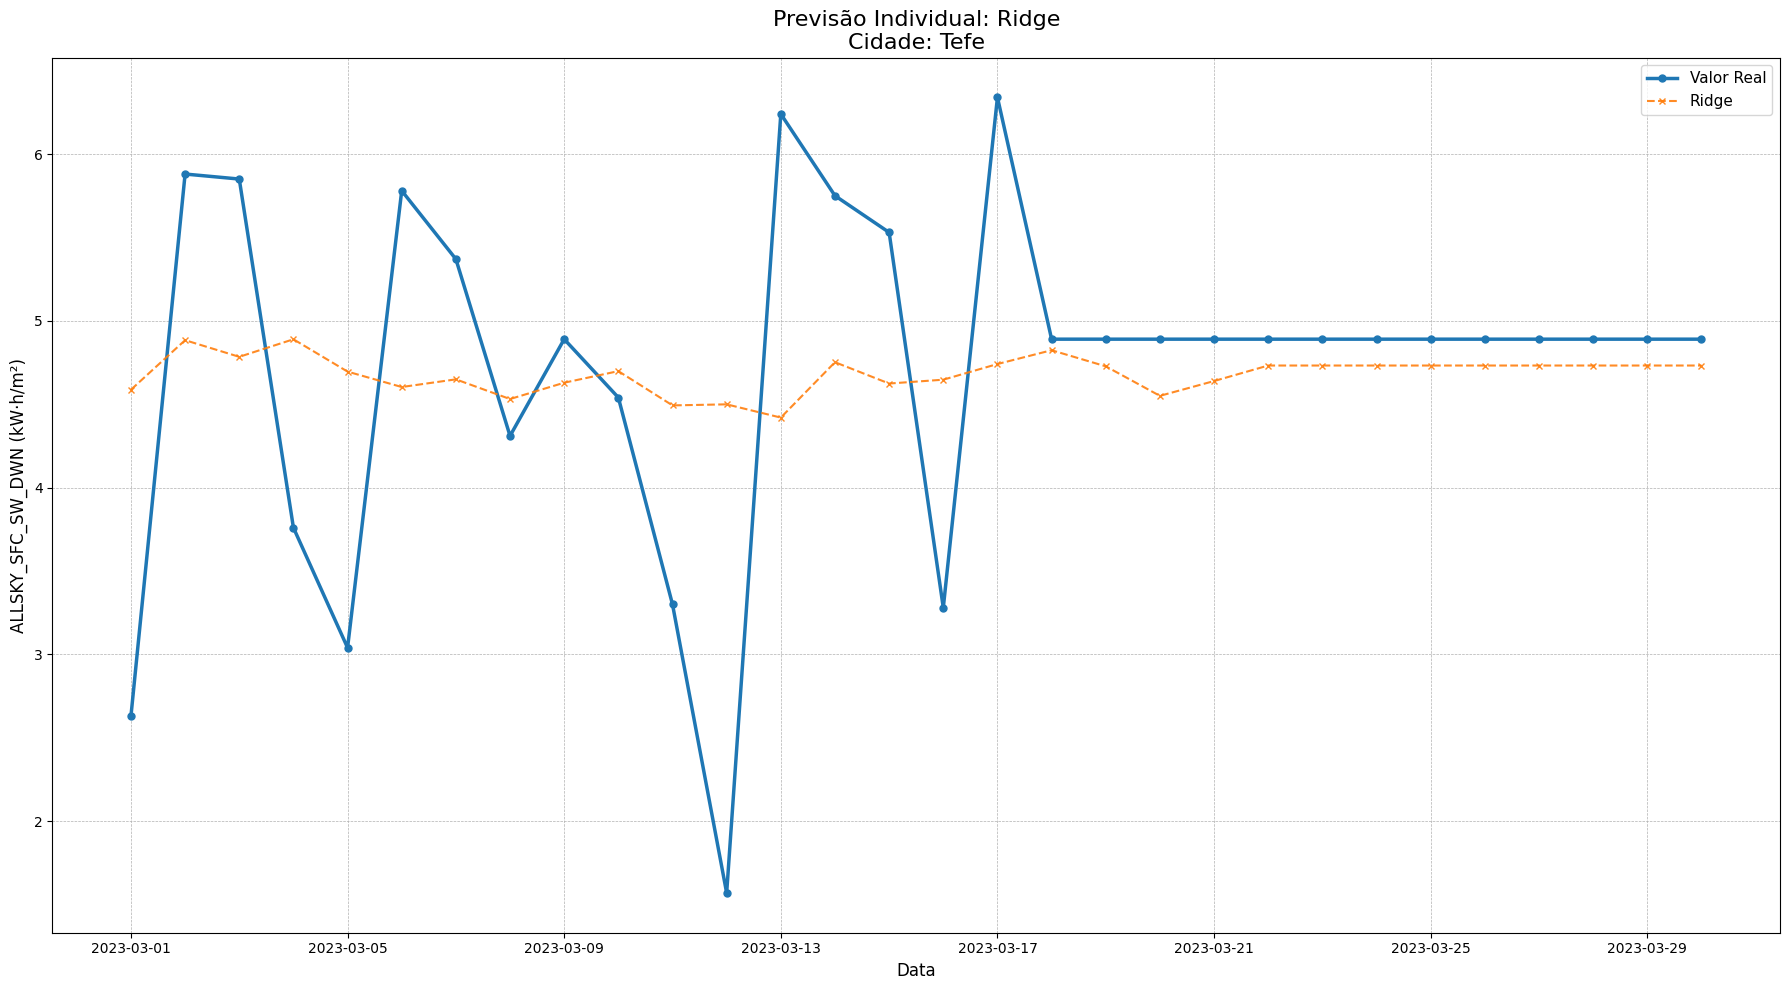

O modelo Ridge não possui o atributo 'feature_importances_'.

Treinando SVR
Gerando gráfico individual para: SVR


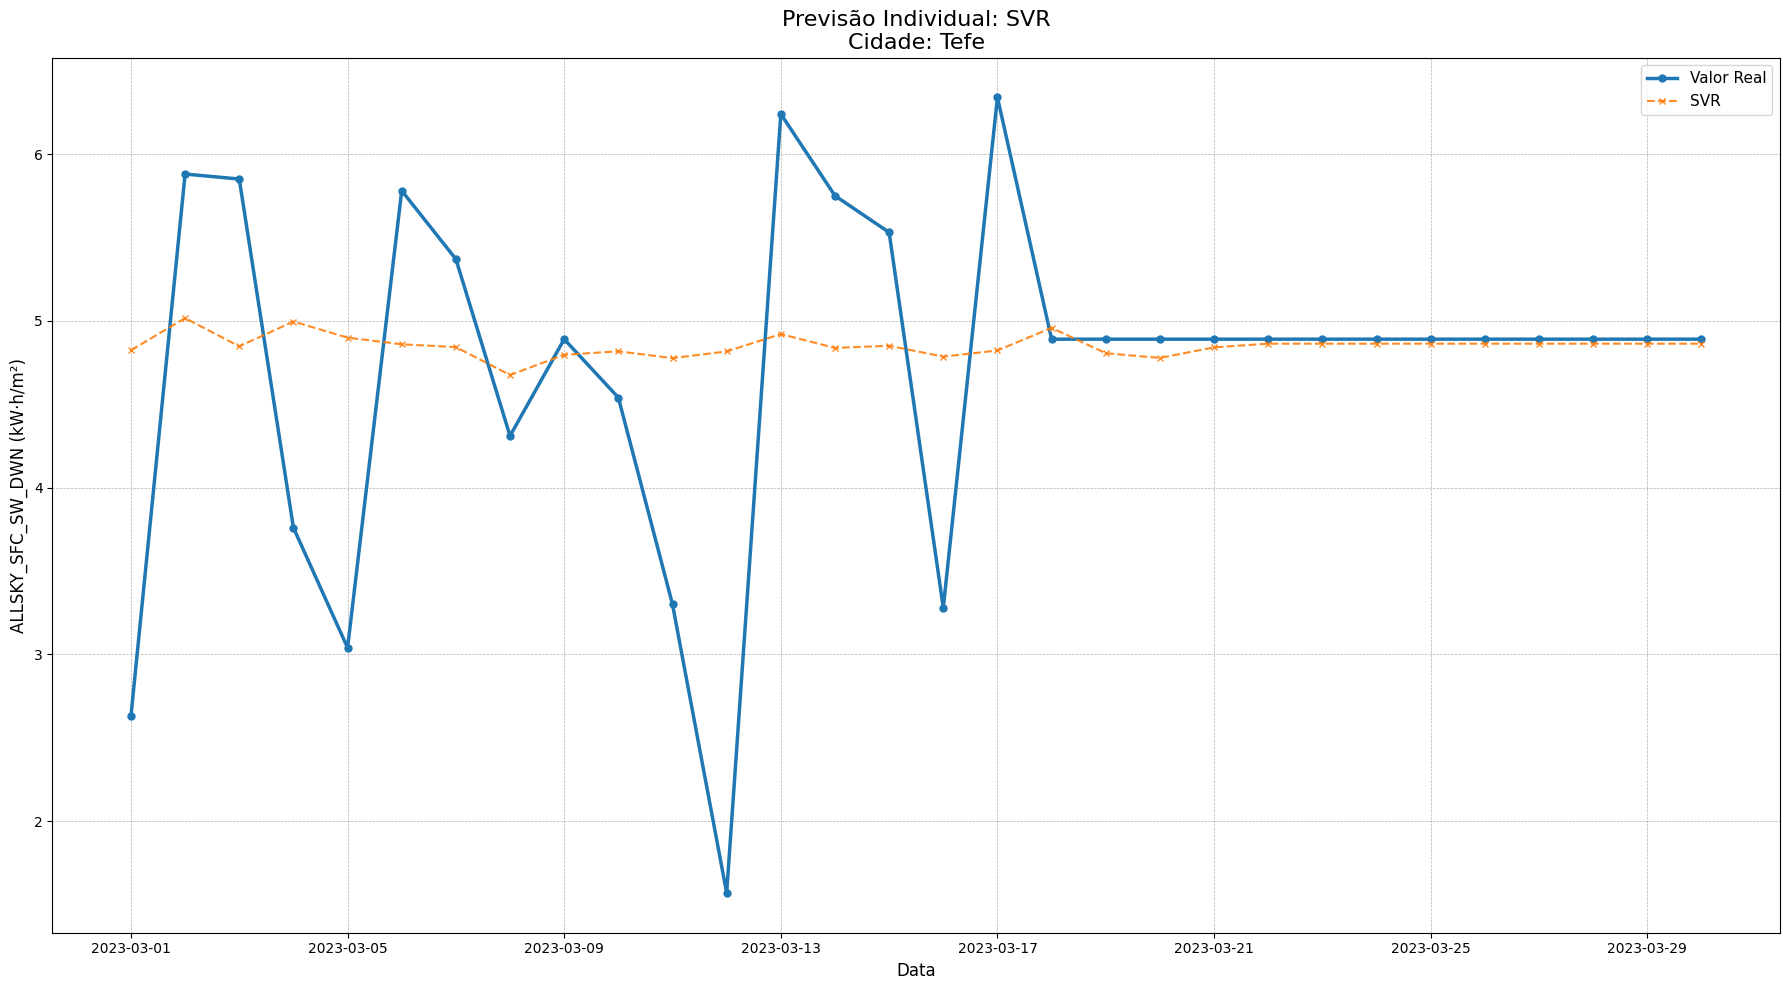

O modelo SVR não possui o atributo 'feature_importances_'.

Treinando Random Forest
Gerando gráfico individual para: Random Forest


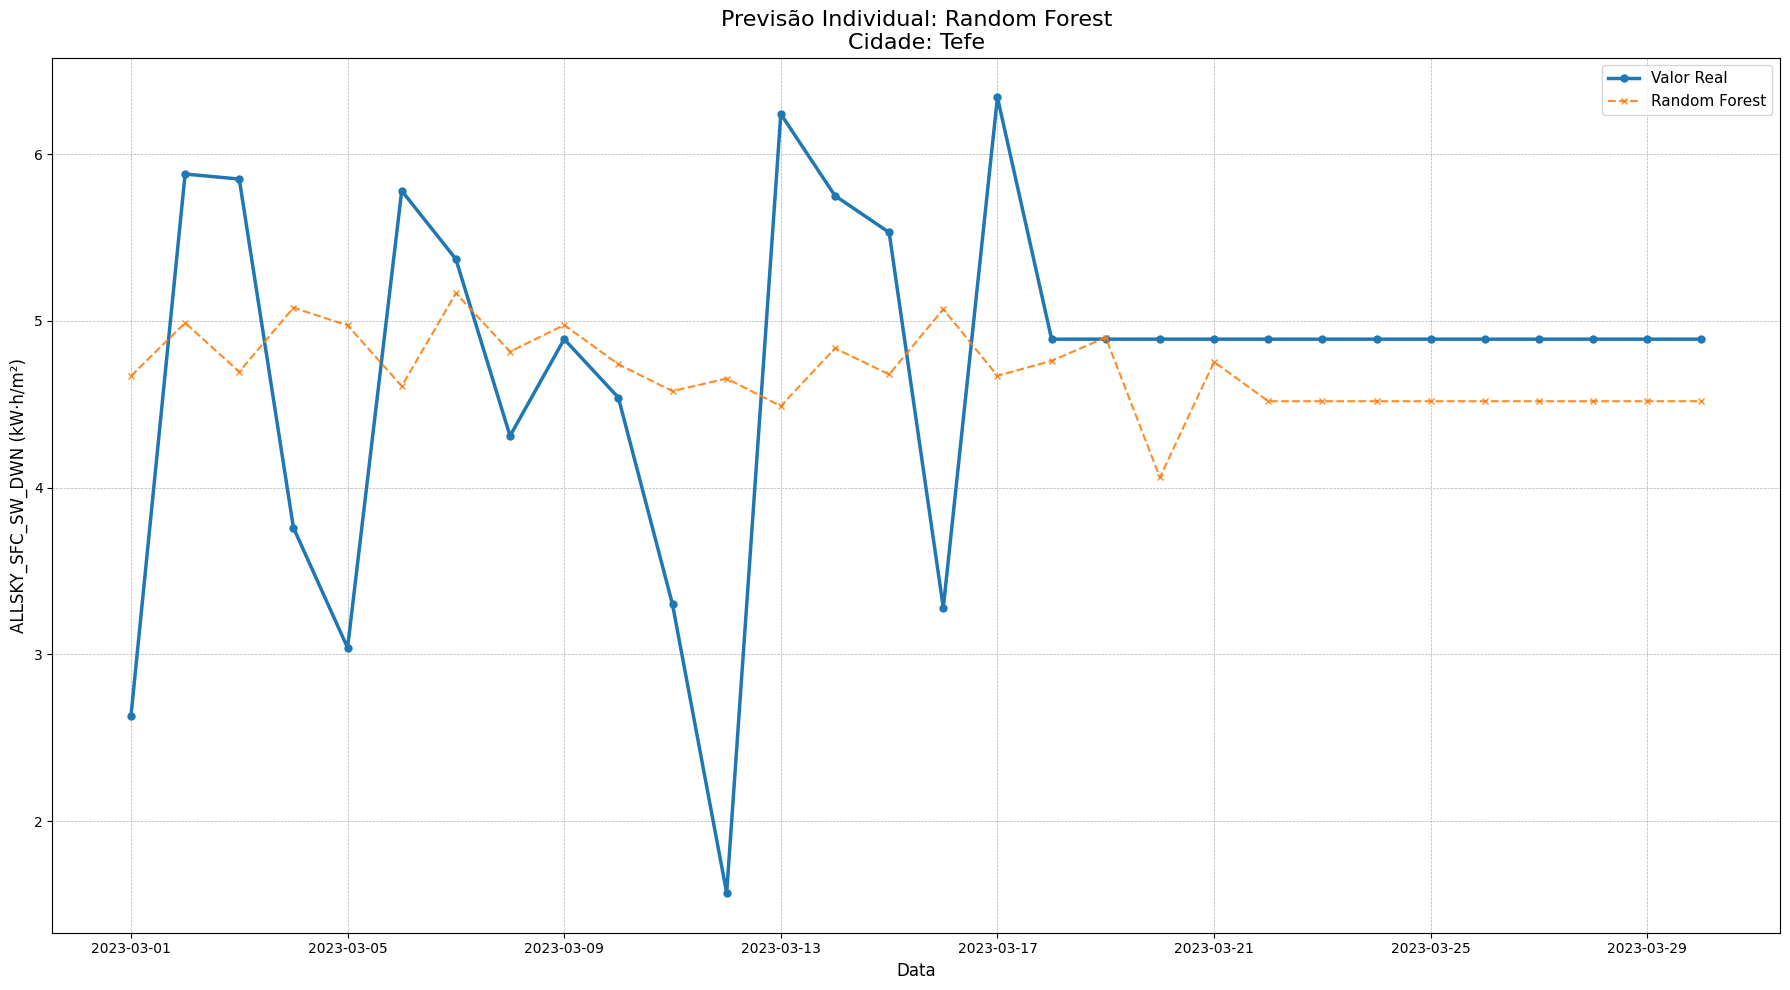

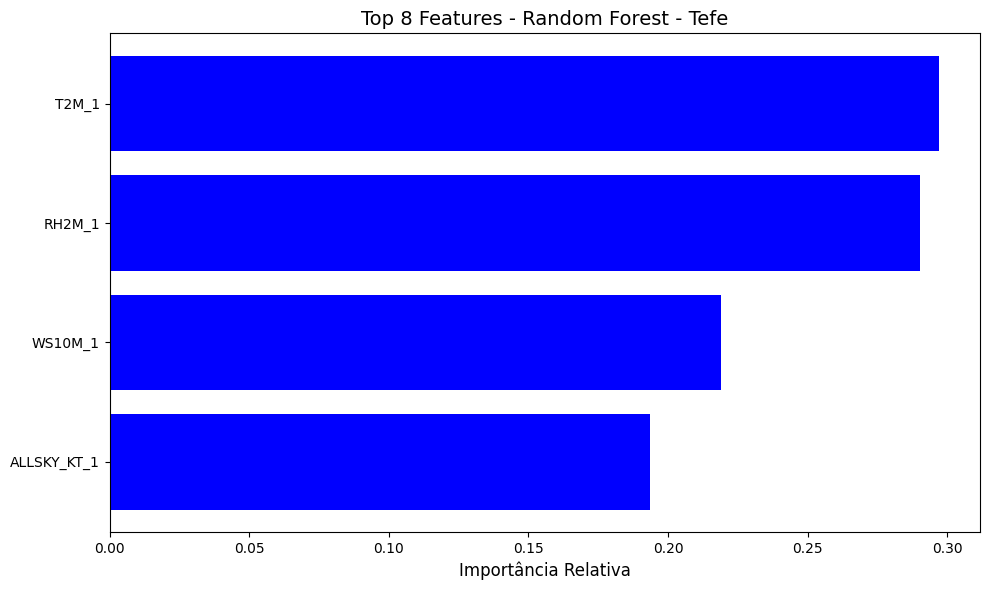


Treinando XGBoost
Gerando gráfico individual para: XGBoost


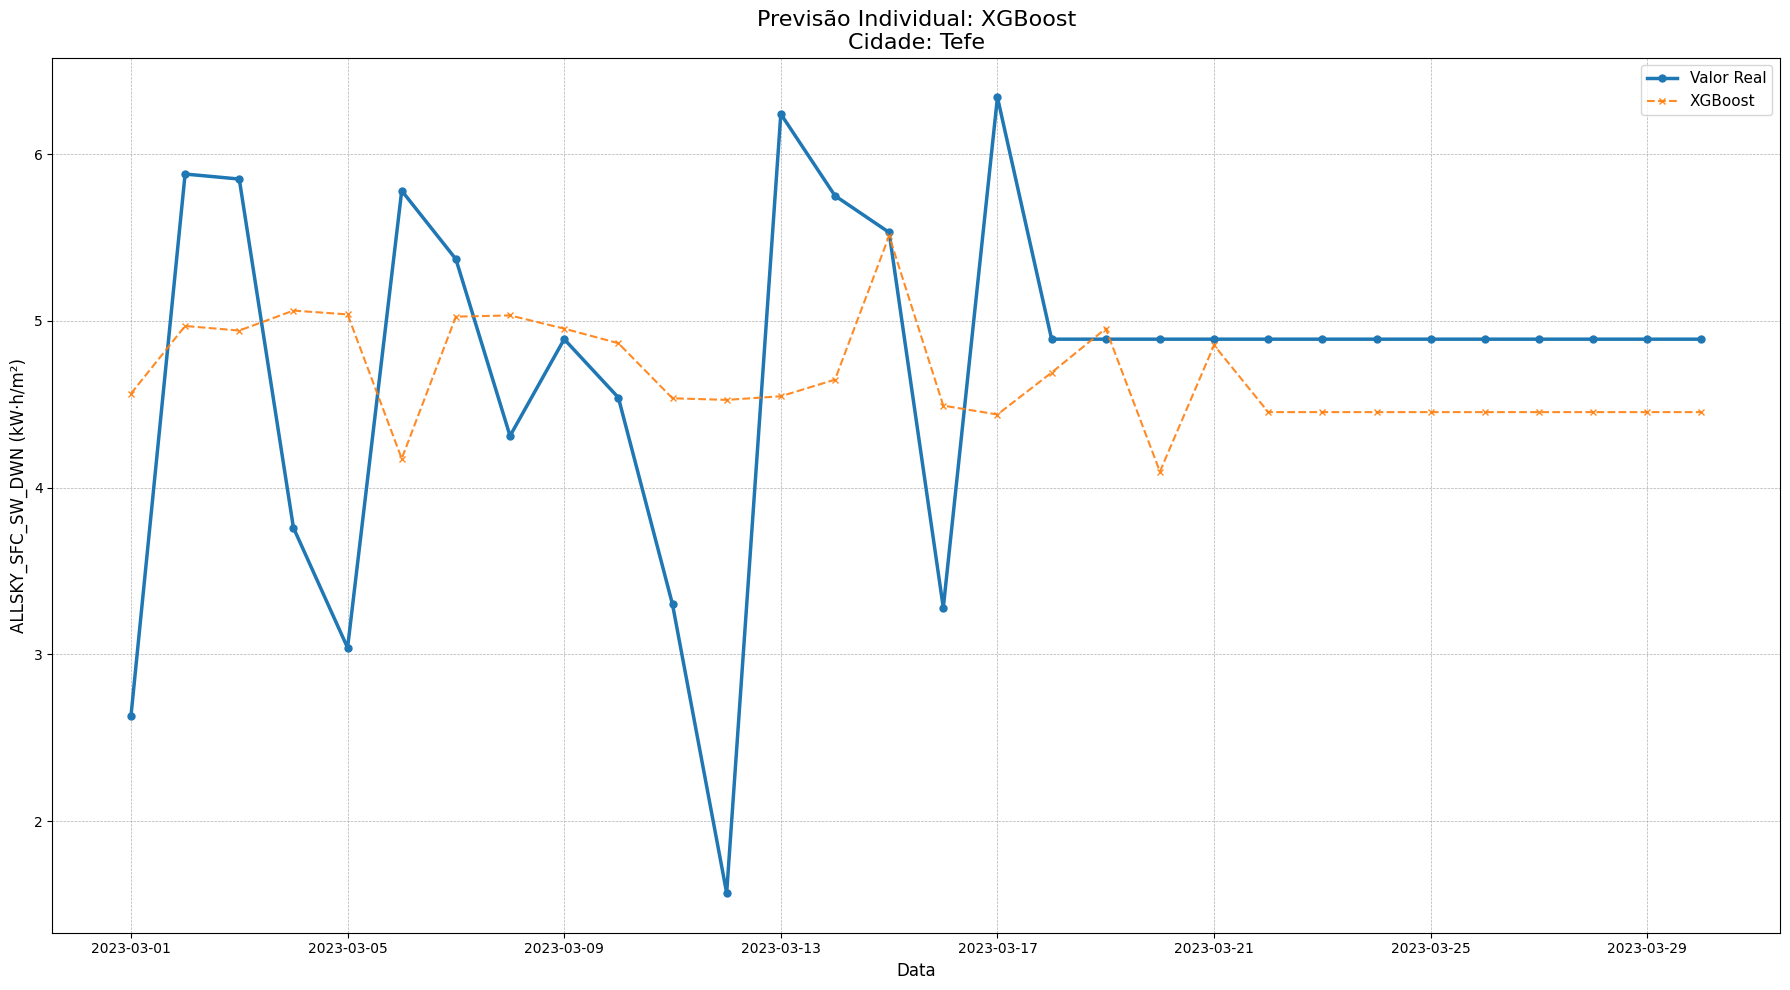

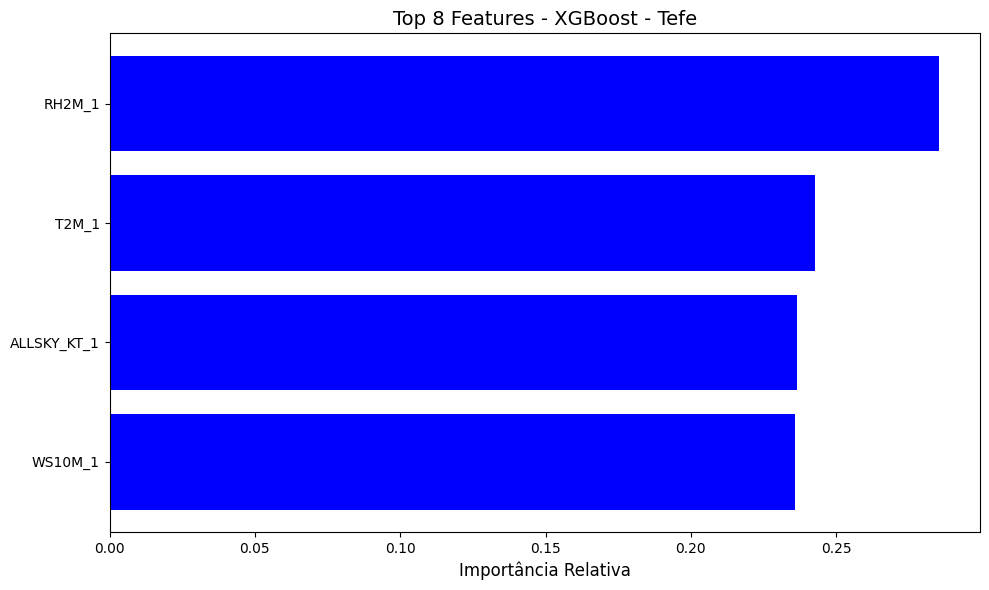


--- Treinamento Concluído ---


In [129]:
# Dicionário central de modelos
models_to_run = {
    "Ridge": Ridge(
        alpha=1.0,
        solver='sag', 
        random_state=RANDOM_STATE
    ),
    "SVR": SVR(
        kernel="rbf",
        C=10.0, 
        epsilon=0.1, 
        gamma="scale"
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=500, 
        random_state=RANDOM_STATE, 
        n_jobs=1
    ),
    "XGBoost": xgb.XGBRegressor(
        objective="reg:squarederror", 
        n_estimators=400, 
        learning_rate=0.06,
        max_depth=6, 
        subsample=0.8, 
        colsample_bytree=0.8, 
        tree_method="hist",
        random_state=RANDOM_STATE,
        importance_type='gain', 
        n_jobs=1
    )
}

# Listas para armazenar resultados
predictions = {}
results_list = []
trained_models = {}

print("--- Iniciando Treinamento e Avaliação ---")

# Loop principal de treinamento
for name, model_instance in models_to_run.items():
    
    # Treina o modelo e obtém resultados
    y_pred, metrics, trained_model = fit_predict_eval(
        model=model_instance,
        X_train=X_train_scaled,
        y_train=y_train,
        X_test=X_test_scaled,
        y_test=y_test,
        y_train_baseline=y_train, # Usado para calcular MASE
        model_name=name,
        station_name=STATION
    )
    
    # Armazena os resultados para a comparação final
    predictions[name] = y_pred
    results_list.append(metrics)
    trained_models[name] = trained_model
    
    # Plotar o gráfico individual para este modelo
    print(f"Gerando gráfico individual para: {name}")
    plot_comparison(
        test_index=y_test.index,
        y_true=y_test.values,
        preds_dict={name: y_pred},
        title=f"Previsão Individual: {name}",
        station_name=STATION,
        target_var=TARGET_VARIABLE,
        save=SAVE_PLOTS,
        folder=PLOTS_FOLDER
    )

    # Plotar importância das features (se aplicável)
    plot_feature_importance(
        model=trained_model,
        feature_names=X_train.columns,
        model_name=name,
        station_name=STATION,
        save=SAVE_PLOTS,
        folder=PLOTS_FOLDER
    )

print("\n--- Treinamento Concluído ---")

### 6 Resultados e Comparações

In [130]:
results_df = pd.DataFrame(results_list).sort_values("MAE").reset_index(drop=True)
save_result(results_df, STATION, RESULTS_FOLDER, save=SAVE_RESULTS)

print("\n=== Replicação — Resultados ===")
display(results_df)


=== Replicação — Resultados ===


,Model,Station,R2,MSE,MAE,MAPE,RMSE,sMAPE(%),MASE,Time(s)
0,SVR,Tefe,0.0089,1.1084,0.6851,21.1185,1.0528,16.0104,0.6181,0.23
1,Ridge,Tefe,0.0458,1.0671,0.7465,21.3396,1.0330,17.3650,0.6736,0.00
2,XGBoost,Tefe,-0.0801,1.2080,0.8422,23.5512,1.0991,19.5020,0.7599,0.15
3,Random Forest,Tefe,-0.1091,1.2404,0.8432,23.9839,1.1137,19.4192,0.7607,3.04


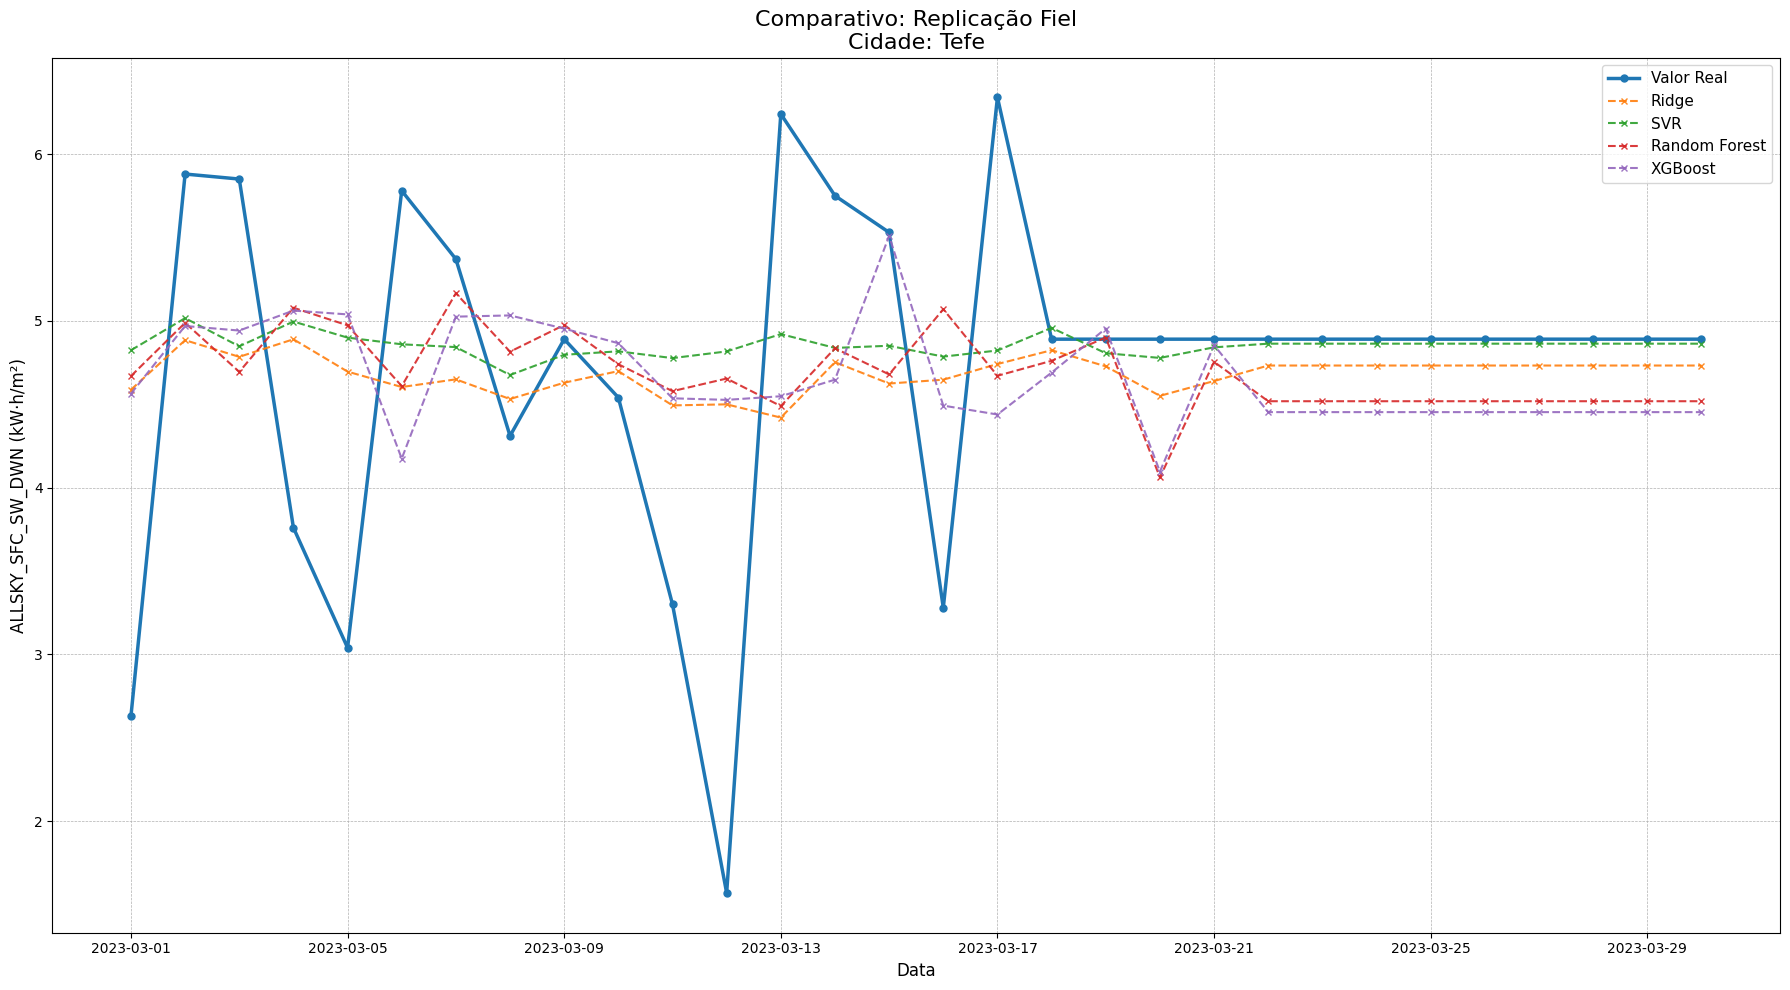

In [131]:
plot_comparison(
    test_index=y_test.index,
    y_true=y_test.values,
    preds_dict=predictions,
    title="Comparativo: Replicação Fiel",
    station_name=STATION,
    target_var=TARGET_VARIABLE,
    save=SAVE_PLOTS,
    folder=PLOTS_FOLDER
)

### 7. Backtesting (Origem Rolante)

In [132]:
if DO_BACKTEST:
    print("\n== Iniciando Backtesting (Origem Rolante) ==")

    X_full, y_full = build_features(df, TARGET_VARIABLE, WEATHER_FEATURES)

    # Espaços de busca para o backtest
    PARAMS_RIDGE_BT = {'alpha': sp_uniform(0.01, 100)} 
    PARAMS_SVR_BT   = {'kernel': ['linear','rbf'],
                   'C': sp_uniform(0.1, 100),
                   'gamma': sp_uniform(1e-4, 1e-1),
                   'epsilon': sp_uniform(0.01, 0.5)}
    PARAMS_RF_BT    = {'n_estimators': sp_randint(200, 800),
                   'max_depth': [None, 10, 20],
                   'min_samples_split': sp_randint(2, 20),
                   'min_samples_leaf': sp_randint(1, 10)}
    PARAMS_XGB_BT   = {'n_estimators': sp_randint(200, 800),
                   'learning_rate': sp_uniform(0.01, 0.15),
                   'max_depth': sp_randint(3, 10),
                   'subsample': sp_uniform(0.6, 0.4)}

    # Executar Backtests
    ridge_bt = rolling_backtest_sklearn(Ridge(random_state=RANDOM_STATE), PARAMS_RIDGE_BT,
                                      X_full, y_full, n_splits=N_CV_SPLITS, gap=SIMPLE_GAP,
                                      n_iter=N_ITER_BACKTEST, name='Ridge', needs_scaler=True)

    svr_bt   = rolling_backtest_sklearn(SVR(), PARAMS_SVR_BT,
                                      X_full, y_full, n_splits=N_CV_SPLITS, gap=SIMPLE_GAP,
                                      n_iter=N_ITER_BACKTEST, name='SVR', needs_scaler=True)

    rf_bt   = rolling_backtest_sklearn(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1), PARAMS_RF_BT,
                                      X_full, y_full, n_splits=N_CV_SPLITS, gap=SIMPLE_GAP,
                                      n_iter=N_ITER_BACKTEST, name='Random Forest', needs_scaler=False)

    xgb_bt   = rolling_backtest_sklearn(xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist',
                                                       random_state=RANDOM_STATE, importance_type='gain', n_jobs=1),
                                      PARAMS_XGB_BT,
                                      X_full, y_full, n_splits=N_CV_SPLITS, gap=SIMPLE_GAP,
                                      n_iter=N_ITER_BACKTEST, name='XGBoost', needs_scaler=False)
    
    # Consolidar e Exibir Resultados
    all_bt_results = pd.concat([ridge_bt, svr_bt, rf_bt, xgb_bt])
    all_bt_results['Model'] = all_bt_results['Model'].apply(lambda x: x.split(' (')[0])
    all_bt_results['Station'] = STATION

    save_result(all_bt_results, STATION, RESULTS_FOLDER, SAVE_RESULTS, 'backtesting_full')

    mean_bt_results = all_bt_results.groupby('Model', as_index=False).mean(numeric_only=True)
    mean_bt_results['Station'] = STATION
    mean_bt_results = mean_bt_results[['Model', 'Station'] + [c for c in mean_bt_results.columns if c not in ['Station', 'Model']]]
    mean_bt_results = mean_bt_results.sort_values(by='MAE')

    print("\n--- Resultados Médios do Backtesting ---")
    save_result(mean_bt_results, STATION, RESULTS_FOLDER, SAVE_RESULTS, 'backtesting_mean')
    display(mean_bt_results)
else:
    print("\nBacktesting pulado (DO_BACKTEST=False).")


== Iniciando Backtesting (Origem Rolante) ==
Backtest: Ridge - Fold 1/5
Backtest: Ridge - Fold 2/5
Backtest: Ridge - Fold 3/5
Backtest: Ridge - Fold 4/5
Backtest: Ridge - Fold 5/5
Backtest: SVR - Fold 1/5
Backtest: SVR - Fold 2/5
Backtest: SVR - Fold 3/5
Backtest: SVR - Fold 4/5
Backtest: SVR - Fold 5/5
Backtest: Random Forest - Fold 1/5
Backtest: Random Forest - Fold 2/5
Backtest: Random Forest - Fold 3/5
Backtest: Random Forest - Fold 4/5
Backtest: Random Forest - Fold 5/5
Backtest: XGBoost - Fold 1/5
Backtest: XGBoost - Fold 2/5
Backtest: XGBoost - Fold 3/5
Backtest: XGBoost - Fold 4/5
Backtest: XGBoost - Fold 5/5

--- Resultados Médios do Backtesting ---


,Model,Station,R2,MSE,MAE,MAPE,RMSE,sMAPE(%),MASE,Time(s)
2,SVR,Tefe,0.02440,1.22690,0.85546,24.36266,1.10478,19.33992,0.80168,0.310
3,XGBoost,Tefe,0.04714,1.19666,0.86394,23.60224,1.09140,19.58464,0.80958,1.484
0,Random Forest,Tefe,0.03734,1.20962,0.86932,23.74746,1.09718,19.69456,0.81466,5.018
1,Ridge,Tefe,0.03388,1.21646,0.87066,24.08178,1.09976,19.67366,0.81594,0.062
